In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer
from sklearn.cluster import KMeans
import os

# Set paths
base_dir = "/workspace/C683_Assignment"
data_dir = os.path.join(base_dir, "prize-data")
movie_titles = os.path.join(data_dir, "movie_titles.csv")

In [2]:
df = pd.read_csv(movie_titles)
display(df.head())

## GLOBAL PARAMETERS
MAX_POPULARITY = 150.

,Unnamed: 0,Unnamed: 0.1,id,year,title,id_moviedb,genre_ids,vote_average,media_type,popularity,...,genre.Romance,genre.Fantasy,genre.Family,genre.Crime,genre.Drama,genre.Music,genre.History,genre.TV Movie,genre.War,genre.Western
0,0,0,17,2005,7 Seconds,9721,"[28, 80, 53]",5,movie,12.895,...,0,0,0,1,0,0,0,0,0,0
1,1,1,85,2005,Elfen Lied,550300,"[28, 16, 18, 27, 10749, 878]",7,movie,2.681,...,1,0,0,0,1,0,0,0,0,0
2,2,2,91,2005,WWE: Royal Rumble 2005,58649,"[28, 18]",7,movie,11.739,...,0,0,0,0,1,0,0,0,0,0
3,3,3,149,2005,The Edward R. Murrow Collection,0,NaN,0,unknown,0.000,...,0,0,0,0,0,0,0,0,0,0
4,4,4,151,2005,Sleepover Nightmare,13568,[27],3,movie,6.800,...,0,0,0,0,0,0,0,0,0,0


Feature: popularity (per https://developers.themoviedb.org/3/getting-started/popularity)
count    17770.000000
mean        11.442455
std         23.673605
min          0.000000
25%          3.316250
50%          7.419000
75%         11.489000
max       1156.177000
Name: popularity, dtype: float64

Found 0 entries with missing popularity
Clipping value for 65 entries with popularity >150.00



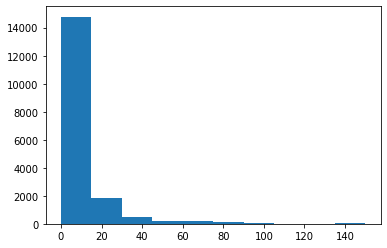

In [3]:
print("Feature: popularity (per https://developers.themoviedb.org/3/getting-started/popularity)")
popularity = pd.to_numeric(df["popularity"], errors='coerce')
print(popularity.describe())
print()
print("Found %d entries with missing popularity" % popularity.isna().sum())
print("Clipping value for %d entries with popularity >%.02f" % ((popularity>MAX_POPULARITY).sum(), MAX_POPULARITY))
popularity = popularity.clip(upper=MAX_POPULARITY)
plt.hist(popularity)
print()

Feature: year
count    17770.000000
mean      1990.265391
std         16.505791
min       1896.000000
25%       1985.000000
50%       1997.000000
75%       2002.000000
max       2005.000000
Name: year, dtype: float64

Found 0 entries with missing year



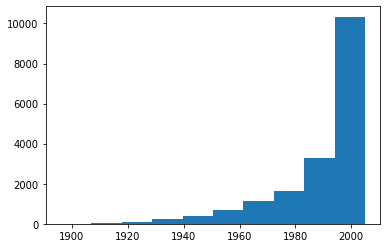

In [4]:
print("Feature: year")
year = pd.to_numeric(df["year"], downcast="unsigned", errors='coerce')
print(year.describe())
print()
print("Found %d entries with missing year" % year.isna().sum())
plt.hist(year)
print()

In [5]:
print("Feature: media_type")
media_type = df["media_type"]
print(media_type.describe())
print()
for i in media_type.unique():
    print("%d '%s' entries" % ((media_type==i).sum(), i))
print("Found %d entries with missing media_type" % media_type.isna().sum())
print()

Feature: media_type
count     17770
unique        3
top       movie
freq      14366
Name: media_type, dtype: object

14366 'movie' entries
1239 'unknown' entries
2165 'tv' entries
Found 0 entries with missing media_type



Feature: vote_average
count    17770.000000
mean        11.009765
std         16.155090
min          0.000000
25%          3.316250
50%          7.419000
75%         11.489000
max        150.000000
Name: popularity, dtype: float64

Found 0 entries with missing vote_average



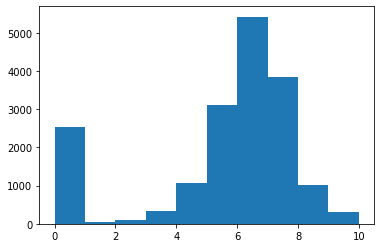

In [6]:
print("Feature: vote_average")
vote_average = pd.to_numeric(df["vote_average"], errors='coerce')
print(popularity.describe())
print()
print("Found %d entries with missing vote_average" % vote_average.isna().sum())
plt.hist(vote_average)
print()

,genre.Adventure,genre.Science Fiction,genre.Documentary,genre.Horror,genre.Action,genre.Animation,genre.Comedy,genre.Thriller,genre.Mystery,genre.Romance,genre.Fantasy,genre.Family,genre.Crime,genre.Drama,genre.Music,genre.History,genre.TV Movie,genre.War,genre.Western
genre.Adventure,1.000000,0.156833,-0.074654,-0.048083,0.305532,0.109091,0.010771,0.031840,-0.032977,-0.035014,0.229016,0.220893,-0.034633,-0.060968,-0.049194,0.057011,0.012066,0.061843,0.044479
genre.Science Fiction,0.156833,1.000000,-0.067233,0.187469,0.165900,0.043963,-0.021762,0.089150,0.010636,-0.060181,0.134639,0.023172,-0.058198,-0.120212,-0.065808,-0.044992,0.012070,-0.030207,-0.027425
genre.Documentary,-0.074654,-0.067233,1.000000,-0.077267,-0.105318,-0.068729,-0.144192,-0.114007,-0.065233,-0.110207,-0.064832,-0.063234,-0.088631,-0.203941,0.171301,0.064085,0.023249,-0.016252,-0.040576
genre.Horror,-0.048083,0.187469,-0.077267,1.000000,-0.013886,-0.058920,-0.075022,0.183693,0.097017,-0.099449,0.071247,-0.081359,-0.053085,-0.152937,-0.073389,-0.040631,-0.005885,-0.043824,-0.030568
genre.Action,0.305532,0.165900,-0.105318,-0.013886,1.000000,-0.035120,-0.051485,0.266735,-0.036141,-0.095932,0.066751,-0.039469,0.157751,-0.041548,-0.098031,0.013853,0.004318,0.080690,0.050384
genre.Animation,0.109091,0.043963,-0.068729,-0.058920,-0.035120,1.000000,0.054550,-0.102262,-0.014760,-0.070075,0.155753,0.309682,-0.075063,-0.132016,-0.045026,-0.044036,-0.006938,-0.041615,-0.034853
genre.Comedy,0.010771,-0.021762,-0.144192,-0.075022,-0.051485,0.054550,1.000000,-0.163343,-0.075315,0.184609,0.059646,0.127085,-0.033728,-0.096786,-0.039655,-0.090838,-0.030485,-0.069257,-0.026243
genre.Thriller,0.031840,0.089150,-0.114007,0.183693,0.266735,-0.102262,-0.163343,1.000000,0.259022,-0.067178,-0.032778,-0.108995,0.284921,0.052255,-0.105891,-0.041451,0.000712,-0.015227,-0.038242
genre.Mystery,-0.032977,0.010636,-0.065233,0.097017,-0.036141,-0.014760,-0.075315,0.259022,1.000000,-0.046961,-0.013564,-0.050298,0.187604,0.088347,-0.058445,-0.035753,0.002935,-0.029095,-0.028659
genre.Romance,-0.035014,-0.060181,-0.110207,-0.099449,-0.095932,-0.070075,0.184609,-0.067178,-0.046961,1.000000,0.022440,-0.041255,-0.060294,0.240509,0.009279,-0.013546,-0.013598,0.018729,0.003417


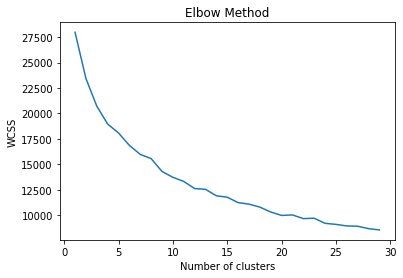

In [7]:
genre_cols = [col for col in df if col.startswith("genre.")]

genre_df = df[genre_cols]
genre_corr = genre_df.corr()
display(genre_corr.style.background_gradient(cmap='coolwarm'))

wcss = []
max_cluster_count = 30
for i in range(1, max_cluster_count):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(genre_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, max_cluster_count), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

,popularity,vote_average
popularity,1.000000,0.300565
vote_average,0.300565,1.000000


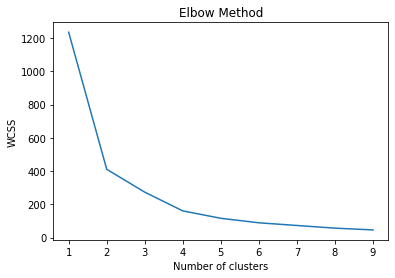

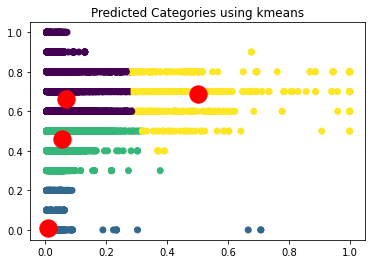

In [8]:
scaler = MinMaxScaler()
p = scaler.fit_transform(popularity.fillna(0.).values.reshape(-1, 1)) # TODO: remove imputation
v = scaler.fit_transform(vote_average.fillna(0.).values.reshape(-1, 1)) # TODO: remove imputation
rating_df = pd.DataFrame({ "popularity": pd.Series(p.T[0]), "vote_average": pd.Series(v.T[0])})
rating_corr = rating_df.corr()
display(rating_corr.style.background_gradient(cmap='coolwarm'))

wcss = []
max_cluster_count = 10
for i in range(1, max_cluster_count):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rating_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, max_cluster_count), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(rating_df)
plt.scatter(p, v, c=clusters)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.title('Predicted Categories using kmeans')
plt.show()